# Bolivian Football League Betting Odds
## 3. Model Creation

The purpose of this notebook is to create a base model to benchmark other algorithms against, and then modelling the resulting data from the previous feature engineering notebook (notebook # 2) using different machine learning supervised learning classifiers.

The resulting predictions are then used in a piece of code which simulates bets placed using our newly developed model on historical matches to check the outcome of a hypothetical initial investment.

In [682]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
import math
import sklearn
style.use('fivethirtyeight')

# Importing SKLEARN packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# load dataset
odds = pd.read_csv('/Users/miketondu/Dropbox/Data Science/Sharpest Minds/odds_data/bolivian_football_odds_prepared.csv',
                  parse_dates= ['date'])


# Choosing columns to train model with 
odds = odds.loc[:,[ 'match_href', 
                    #'bookmakers',
                    'home_odds', 'draw_odds', 'away_odds',
                    'payout', 
                    #'date', 
                    #'time', 
                    'season_year', 
                    'home_team', 'away_team',
                    'home_goals', 'away_goals',
                    'implied_home_odds', 'implied_draw_odds', 'implied_away_odds',
                    #'win_home_or_away', 
                    'home_win', 
                    #'away_win',             
                    #'over',                    
                    'altitude','tropics',
                    'season_win_home_team', 'season_win_away_team', 
                    'season_loss_home_team', 'season_loss_away_team', 
                    'season_points_home_team','season_points_away_team', 
                    'season_games_played_home_team','season_games_played_away_team',
                    'season_goals_home_team','season_goals_away_team',
                    'season_goals_allowed_home_team', 'season_goals_allowed_away_team',
                    'season_win_first_h_home_team', 'season_win_first_h_away_team',
                    'season_win_second_h_home_team', 'season_win_second_h_away_team']]

odds.shape
#odds.info()
odds['season_year'] = odds.season_year.astype('category')

# Creating Unique matches dataframe
odds_unique = odds.drop_duplicates('match_href').drop('match_href', axis=1)

(20953, 32)

### Base Model
For the purpose of having a base model to compare all other iterations of our model against, we will create a one which will predict a home team win 100% of the time.

In [683]:
# model_df
model_df = odds_unique.copy()
target_var = 'home_win'

# Creating X and Y
X = np.ones(len(odds_unique)).reshape(-1, 1)
y = model_df[target_var]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Score on test set
print('Accuracy of base model predicting only home wins: ', dt.score(X_test, y_test));

Accuracy of base model predicting only home wins:  0.551048951048951


### Modelling

In [684]:
# Preparing dataframe to feed it into the model
#target_var = 'home_win'

model_df = odds_unique.copy().dropna()
model_df.drop(['home_goals', 'away_goals'],axis=1,inplace=True)
X = model_df.loc[:,model_df.columns!=target_var] 
X = pd.get_dummies(X)
y = model_df.loc[:,target_var]

X.shape
y.shape

(2860, 77)

(2860,)

#### Train/Test Split
This code utilizes a series of Machine Learning algorithms splitting the data into a train and test set

/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR : 0.6695804195804196
KNN : 0.5437062937062938
CART : 0.5472027972027972
NB : 0.6381118881118881


/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM : 0.5506993006993007
LDA : 0.6625874125874126


/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


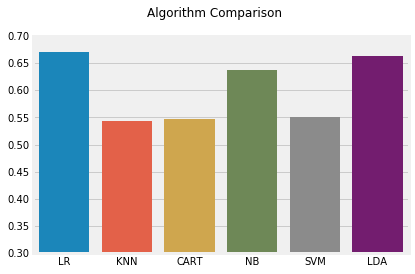

In [800]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
models.append(('LDA', LinearDiscriminantAnalysis()))

results = []
names = []
y_preds = []

for model in models:
    # Choose model
    clf = model[1]
    # Train the model on training data
    clf.fit(X_train, y_train)
    # Prediction on test set
    y_pred=clf.predict_proba(X_test)
    # Print results
    print(model[0],':', clf.score(X_test,y_test))
    names.append(model[0])
    results.append(clf.score(X_test,y_test))
    
    
# barplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
sns.barplot(x=names,y=results)
ax.set_ylim((.3,.7))
plt.show();



#### Cross-validation
This code utilizes a cross-validation approach to train the ML models

/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will 

LR: 0.631119 (0.015715)
KNN: 0.559091 (0.013333)
CART: 0.570979 (0.020525)
NB: 0.604196 (0.054388)


/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/miketondu/anaconda3/lib/python3.6/si

SVM: 0.577972 (0.019010)
LDA: 0.613287 (0.050384)


/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/miketondu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


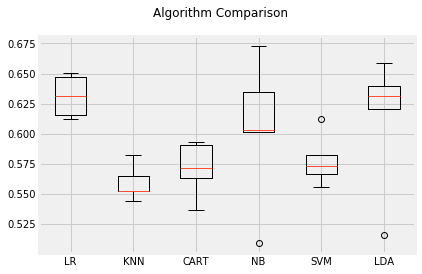

In [801]:
# Compare Algorithms
# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('LDA', LinearDiscriminantAnalysis()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

## Bet simulator
This section uses the predictions obtained in the previous one and simulates having bet on historical matches in order to find out how many of them would've been winning propositions and how much money would've been made or lost using this instance of this model.

In [805]:
# Concatenating predictions with its matching dataset
predictions = pd.DataFrame(y_pred).set_index(X_test.index)
df = pd.concat([odds, predictions], axis=1,join='inner')
#df = df[df['season_year']==2014]


def kelly(odds,p):
    ''' Kelly criterion formula outputs the fraction of your bankroll to bet depending on the odds predicted
    f = fraction of the bankroll to bet
    b = decimal odds -1
    p = implied probability of our model
    q = probability of losing (1-p)
     '''
    b = odds - 1
    f = (b*p-(1-p))/b
    
    return f


def model_bet_simulator(dataframe, starting_bankroll):
    bets_won = 0
    bets_lost = 0
    bankroll = starting_bankroll

    for i in range(len(dataframe)):
        home_team = dataframe['home_team'].values[i]
        away_team = dataframe['away_team'].values[i]

        home_goals = dataframe['home_goals'].values[i]
        away_goals = dataframe['away_goals'].values[i]

        home_odds = dataframe['home_odds'].values[i]
        draw_odds = dataframe['draw_odds'].values[i]
        away_odds = dataframe['away_odds'].values[i]
        
        prediction = dataframe[1].values[i]
        
        # Kelly
        wagering_size = .02#kelly(home_odds,prediction)/4
        
        # Simulating bets
        if prediction > (1/home_odds):
            if home_goals > away_goals:
                bets_won += 1
                bankroll += (bankroll * wagering_size) * (home_odds - 1)
            else:
                bets_lost += 1
                bankroll -= bankroll * wagering_size

    ROI = round((bankroll - starting_bankroll) / starting_bankroll * 100,2)
    print ("There were '%s' bets won out of '%s' total bets placed, or '%s' percent won" % 
           (bets_won, bets_won+bets_lost, round(bets_won/(bets_won+bets_lost)*100,2)))
    
    print ("Starting bankroll = '%s'" % (starting_bankroll))
    print ("Finishing bankroll = '%s' | ROI = '%s'" % (bankroll, ROI))
    
model_bet_simulator(df,10000)

There were '177' bets won out of '282' total bets placed, or '62.77' percent won
Starting bankroll = '10000'
Finishing bankroll = '15982.411174398489' | ROI = '59.82'


In [804]:
for year in df.season_year.unique():
    print(year,':')
    print( model_bet_simulator(df[df['season_year']==year],10000))

model_bet_simulator(df, 10000);

2009 :
There were '8' bets won out of '11' total bets placed, or '72.73' percent won
Starting bankroll = '10000'
Finishing bankroll = '10993.726167515795' | ROI = '9.94'
None
2010 :
There were '25' bets won out of '34' total bets placed, or '73.53' percent won
Starting bankroll = '10000'
Finishing bankroll = '11888.422225069295' | ROI = '18.88'
None
2011 :
There were '23' bets won out of '35' total bets placed, or '65.71' percent won
Starting bankroll = '10000'
Finishing bankroll = '10831.617559439228' | ROI = '8.32'
None
2012 :
There were '12' bets won out of '18' total bets placed, or '66.67' percent won
Starting bankroll = '10000'
Finishing bankroll = '10409.013961036293' | ROI = '4.09'
None
2013 :
There were '15' bets won out of '24' total bets placed, or '62.5' percent won
Starting bankroll = '10000'
Finishing bankroll = '9987.558648602808' | ROI = '-0.12'
None
2014 :
There were '28' bets won out of '43' total bets placed, or '65.12' percent won
Starting bankroll = '10000'
Finishi